In [1]:
import numpy as np
from scipy import sparse as sp
from scipy.sparse.linalg import spsolve
from matplotlib import pyplot as plt
from matplotlib import cm
from mpl_toolkits.mplot3d import Axes3D
import time, sys
import pickle
from scipy.io import savemat, loadmat

In [2]:
np.set_printoptions(threshold=sys.maxsize)

In [3]:
# Choose either Re=1000 or Re=100
Re=10000

In [4]:
# Set parameters
if Re==10000:
    nx=60
    ny=60
    nt=1500
elif Re==100:
    nx=60
    ny=60
    nt=1500
else:
    raise NameError('{} is given for Re, but it must be either 100 or 10000'.format(Re))
    
nxy=(nx-2)*(ny-2)
dx=1/(nx-1)
dy=1/(ny-1)
dt=2/nt

I=sp.eye(nxy,format='csr')

# full indicies, free indicies, fixed indicies
[xv,yv]=np.meshgrid(np.linspace(0,1,nx),np.linspace(0,1,ny),indexing='xy')
x=xv.flatten()
y=yv.flatten()

multi_index_i,multi_index_j=np.meshgrid(np.arange(nx),np.arange(ny),indexing='xy')
full_multi_index=(multi_index_j.flatten(),multi_index_i.flatten())
free_multi_index=(multi_index_j[1:-1,1:-1].flatten(),multi_index_i[1:-1,1:-1].flatten())
x0_multi_index=(multi_index_j[1:-1,0].flatten(),multi_index_i[1:-1,0].flatten())
x1_multi_index=(multi_index_j[1:-1,-1].flatten(),multi_index_i[1:-1,-1].flatten())
y0_multi_index=(multi_index_j[0,1:-1].flatten(),multi_index_i[0,1:-1].flatten())
y1_multi_index=(multi_index_j[-1,1:-1].flatten(),multi_index_i[-1,1:-1].flatten())

dims=(ny,nx)
full_raveled_indicies=np.ravel_multi_index(full_multi_index,dims)
free_raveled_indicies=np.ravel_multi_index(free_multi_index,dims)
x0_raveled_indicies=np.ravel_multi_index(x0_multi_index,dims)
x1_raveled_indicies=np.ravel_multi_index(x1_multi_index,dims)
x01_raveled_indicies=np.concatenate((x0_raveled_indicies,x1_raveled_indicies))
y0_raveled_indicies=np.ravel_multi_index(y0_multi_index,dims)
y1_raveled_indicies=np.ravel_multi_index(y1_multi_index,dims)
y01_raveled_indicies=np.concatenate((y0_raveled_indicies,y1_raveled_indicies))
fixed_raveled_indicies=np.setdiff1d(full_raveled_indicies,free_raveled_indicies)

# boundary one-hot vector
x0_one_hot=np.eye(nx-2)[0]
y0_one_hot=np.eye(ny-2)[0]
x1_one_hot=np.eye(nx-2)[-1]
y1_one_hot=np.eye(ny-2)[-1]

# inner grid
inner_multi_index_i,inner_multi_index_j=np.meshgrid(np.arange(nx-2),np.arange(ny-2),indexing='xy')
inner_x_multi_index=(np.concatenate((inner_multi_index_j[:,0].flatten(),inner_multi_index_j[:,-1].flatten())),
                     np.concatenate((inner_multi_index_i[:,0].flatten(),inner_multi_index_i[:,-1].flatten())))
inner_y_multi_index=(np.concatenate((inner_multi_index_j[0,:].flatten(),inner_multi_index_j[-1,:].flatten())),
                     np.concatenate((inner_multi_index_i[0,:].flatten(),inner_multi_index_i[-1,:].flatten())))

inner_dims=(ny-2,nx-2)
inner_x_raveled_indicies=np.ravel_multi_index(inner_x_multi_index,inner_dims)
inner_y_raveled_indicies=np.ravel_multi_index(inner_y_multi_index,inner_dims)

In [5]:
# first order derivative
# central
Mb=sp.diags([np.ones(nx-2),-np.ones(nx-2)],[0,-1],(nx-2,nx-2))
M=sp.kron(sp.eye(ny-2),Mb,format="csr")

Ib=sp.eye(nx-2)
N=sp.kron(sp.diags([np.ones(ny-2),-np.ones(ny-2)],[0,-1],(ny-2,ny-2)),Ib,format="csr")

# laplacian operator
Dxb=sp.diags([-2*np.ones(nx-2),np.ones(nx-2),np.ones(nx-2)],[0,-1,1],(nx-2,nx-2))
Dx=sp.kron(sp.eye(ny-2),Dxb,format="csr")

Ib=sp.eye(nx-2)
Dy=sp.kron(sp.diags([-2*np.ones(ny-2),np.ones(ny-2),np.ones(ny-2)],[0,-1,1],(ny-2,ny-2)),Ib,format="csr")

In [6]:
if Re==10000:
    file_name_AE="./model/AE_high_Re_v3_batch_240.p"
    latent_dim=5
elif Re==100:
    file_name_AE="./model/AE_low_Re_v3_batch_240.p"
    latent_dim=5
else:
    raise NameError('{} is given for Re, but it must be either 100 or 10000'.format(Re))

AE = pickle.load(open(file_name_AE,'rb'))

en_wu1=AE['en_wu1']
en_bu1=AE['en_bu1']
en_wu2=AE['en_wu2']
de_wu1=AE['de_wu1']
de_bu1=AE['de_bu1']
de_wu2=AE['de_wu2']
de_wu1T=AE['de_wu1T']
de_wu2T=AE['de_wu2T']
de_wu2_sp=AE['de_wu2_sp']
de_wu2T_sp=AE['de_wu2T_sp']
u_ref=AE['u_ref']

en_wv1=AE['en_wv1']
en_bv1=AE['en_bv1']
en_wv2=AE['en_wv2']
de_wv1=AE['de_wv1']
de_bv1=AE['de_bv1']
de_wv2=AE['de_wv2']
de_wv1T=AE['de_wv1T']
de_wv2T=AE['de_wv2T']
de_wv2_sp=AE['de_wv2_sp']
de_wv2T_sp=AE['de_wv2T_sp']
v_ref=AE['v_ref']

In [7]:
M=M.astype('float32')
N=N.astype('float32')

Dx=Dx.astype('float32')
Dy=Dy.astype('float32')

MT=M.T
NT=N.T

Mu_ref=M.dot(u_ref)
Nu_ref=N.dot(u_ref)
Mv_ref=M.dot(v_ref)
Nv_ref=N.dot(v_ref)

Dxu_ref=Dx.dot(u_ref)
Dyu_ref=Dy.dot(u_ref)
Dxv_ref=Dx.dot(v_ref)
Dyv_ref=Dy.dot(v_ref)

In [8]:
def sigmoid_np(input):
    return (1.0/(1.0+np.exp(-input))).astype('float32')

def encoder_u_np_forward(x):
    z1 = en_wu1.dot(x) + en_bu1
    a1 = sigmoid_np(z1)
    y = en_wu2.dot(a1)   
    return y

def decoder_u_np_forward(x):
    z1 = de_wu1.dot(x) + de_bu1
    a1 = sigmoid_np(z1)
    y = de_wu2.dot(a1)  
    return y

def decoder_u_sp_forward(x):
    z1 = de_wu1.dot(x) + de_bu1
    a1 = sigmoid_np(z1)
    y = sp.csr_matrix.dot(de_wu2_sp,a1)
    return y

def encoder_v_np_forward(x):
    z1 = en_wv1.dot(x) + en_bv1
    a1 = sigmoid_np(z1)
    y = en_wv2.dot(a1)   
    return y

def decoder_v_np_forward(x):
    z1 = de_wv1.dot(x) + de_bv1
    a1 = sigmoid_np(z1)
    y = de_wv2.dot(a1)   
    return y

def decoder_v_sp_forward(x):
    z1 = de_wv1.dot(x) + de_bv1
    a1 = sigmoid_np(z1)
    y = sp.csr_matrix.dot(de_wv2_sp,a1)
    return y

def decoder_u_np_forward_backwardT(x):
    z1 = de_wu1.dot(x) + de_bu1
    a1 = sigmoid_np(z1)
    y = de_wu2.dot(a1)

    dout = de_wu1T
    dout = (a1*(1-a1))*dout
    dydxT = dout.dot(de_wu2T)   
    return y,dydxT

def decoder_u_sp_forward_backwardT(x):
    z1 = de_wu1.dot(x) + de_bu1
    a1 = sigmoid_np(z1)
    y = sp.csr_matrix.dot(de_wu2_sp,a1)

    dout = de_wu1T
    dout = (a1*(1-a1))*dout
    dydxT = sp.csr_matrix.dot(dout,de_wu2T_sp)
    return y,dydxT

def decoder_v_np_forward_backwardT(x):
    z1 = de_wv1.dot(x) + de_bv1
    a1 = sigmoid_np(z1)
    y = de_wv2.dot(a1)

    dout = de_wv1T
    dout = (a1*(1-a1))*dout
    dydxT = dout.dot(de_wv2T)   
    return y,dydxT

def decoder_v_sp_forward_backwardT(x):
    z1 = de_wv1.dot(x) + de_bv1
    a1 = sigmoid_np(z1)
    y = sp.csr_matrix.dot(de_wv2_sp,a1)

    dout = de_wv1T
    dout = (a1*(1-a1))*dout
    dydxT = sp.csr_matrix.dot(dout,de_wv2T_sp)
    return y,dydxT

# Galerkin

In [9]:
def theta_u(g_u,g_v,Mg_u,Ng_u):
    return -1/dx*g_u*Mg_u-1/dy*g_v*Ng_u

def theta_v(g_u,g_v,Mg_v,Ng_v):
    return -1/dx*g_u*Mg_v-1/dy*g_v*Ng_v

def dtheta_udu_hatT(g_u,g_v,Mg_u,Jg_uT,Jg_uTMT,Jg_uTNT):
    return -1/dx*(Mg_u*Jg_uT+g_u*Jg_uTMT)-1/dy*g_v*Jg_uTNT

def dtheta_udv_hatT(Ng_u,Jg_vT):
    return -1/dy*Ng_u*Jg_vT

def dtheta_vdu_hatT(Mg_v,Jg_uT):
    return -1/dx*Mg_v*Jg_uT

def dtheta_vdv_hatT(g_u,g_v,Ng_v,Jg_vT,Jg_vTMT,Jg_vTNT):
    return -1/dx*g_u*Jg_vTMT-1/dy*(Ng_v*Jg_vT+g_v*Jg_vTNT)

def r_hat(u_hat,v_hat,u_hat_prev,v_hat_prev,g_u,g_v,Mg_u,Ng_u,Mg_v,Ng_v,Jg_uT_pinv,Jg_vT_pinv,\
          au1_cur,Au2_cur,au3_cur,av1_cur,av2_cur,Av3_cur):
    r_u_hat=u_hat-u_hat_prev-dt*(au1_cur+Au2_cur.dot(g_u)+au3_cur*g_v+theta_u(g_u,g_v,Mg_u,Ng_u)).dot(Jg_uT_pinv)
    r_v_hat=v_hat-v_hat_prev-dt*(av1_cur+av2_cur*g_u+Av3_cur.dot(g_v)+theta_v(g_u,g_v,Mg_v,Ng_v)).dot(Jg_vT_pinv)
    return np.concatenate((r_u_hat,r_v_hat))

def J_hat(g_u,g_v,Mg_u,Ng_u,Mg_v,Ng_v,Jg_uT,Jg_vT,Jg_uTMT,Jg_uTNT,Jg_vTMT,Jg_vTNT):
    J_hat11=(I_hat-dt*(sp.csc_matrix.dot(Jg_uT,Au2T_cur)+dtheta_udu_hatT(g_u,g_v,Mg_u,Jg_uT,Jg_uTMT,Jg_uTNT)).dot(Jg_uT_pinv)).T
    J_hat12=(-dt*(au3_cur*Jg_vT+dtheta_udv_hatT(Ng_u,Jg_vT)).dot(Jg_uT_pinv)).T
    J_hat21=(-dt*(av2_cur*Jg_uT+dtheta_vdu_hatT(Mg_v,Jg_uT)).dot(Jg_vT_pinv)).T
    J_hat22=(I_hat-dt*(sp.csc_matrix.dot(Jg_vT,Av3T_cur)+dtheta_vdv_hatT(g_u,g_v,Ng_v,Jg_vT,Jg_vTMT,Jg_vTNT)).dot(Jg_vT_pinv)).T
    return np.block([[J_hat11,J_hat12],[J_hat21,J_hat22]])


amp=0.85

Time elapsed: 238.82899808883667 sec
average relative error of u: 5.216059545351866%
average relative error of v: 5.313907896110991%
maximum relative error of u: 8.99451931041007%
maximum relative error of v: 9.151938655178792%
maximum relative error: 9.151938655178792%


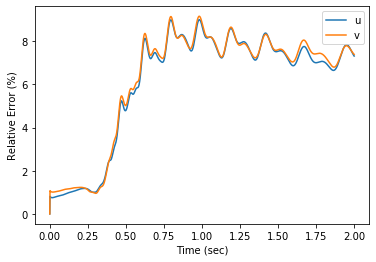


amp=0.86

Time elapsed: 228.62900066375732 sec
average relative error of u: 5.761701571262578%
average relative error of v: 5.842453657336627%
maximum relative error of u: 9.908052442724195%
maximum relative error of v: 10.054858795530993%
maximum relative error: 10.054858795530993%


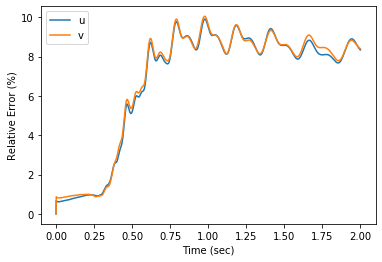


amp=0.87

Time elapsed: 225.18600273132324 sec
average relative error of u: 6.218471675071608%
average relative error of v: 6.28776202545788%
maximum relative error of u: 10.647318335234958%
maximum relative error of v: 10.786465092804285%
maximum relative error: 10.786465092804285%


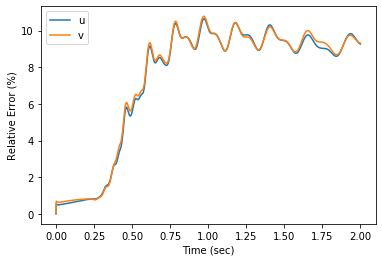


amp=0.88

Time elapsed: 227.8789985179901 sec
average relative error of u: 6.594317557823394%
average relative error of v: 6.655562506921483%
maximum relative error of u: 11.231686222178872%
maximum relative error of v: 11.36468611435934%
maximum relative error: 11.36468611435934%


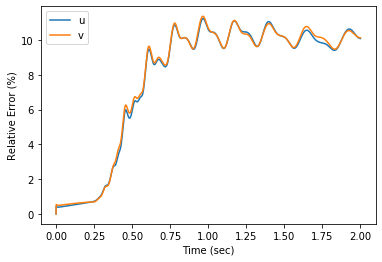


amp=0.89

Time elapsed: 228.03299808502197 sec
average relative error of u: 6.899727569895091%
average relative error of v: 6.95490008686841%
maximum relative error of u: 11.684331118358225%
maximum relative error of v: 11.809916040984682%
maximum relative error: 11.809916040984682%


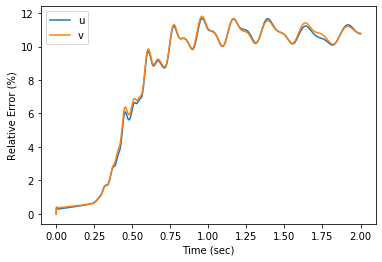


amp=0.9

Time elapsed: 238.82199931144714 sec
average relative error of u: 7.148244679671077%
average relative error of v: 7.198378391368733%
maximum relative error of u: 12.148878678099932%
maximum relative error of v: 12.149037947905192%
maximum relative error: 12.149037947905192%


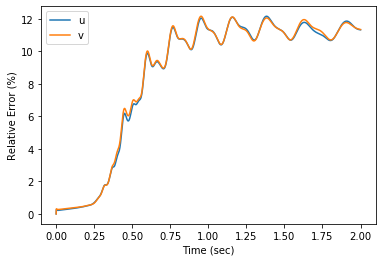


amp=0.91

Time elapsed: 224.15099811553955 sec
average relative error of u: 7.356640468974228%
average relative error of v: 7.402230015828683%
maximum relative error of u: 12.547709881182808%
maximum relative error of v: 12.462284148114328%
maximum relative error: 12.547709881182808%


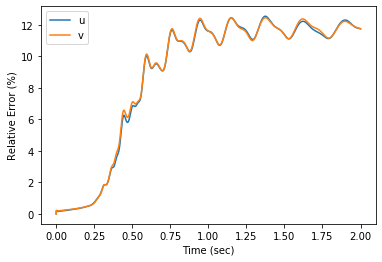


amp=0.92

Time elapsed: 227.97699856758118 sec
average relative error of u: 7.542748910690652%
average relative error of v: 7.584054262698663%
maximum relative error of u: 12.88623452289526%
maximum relative error of v: 12.80684165927669%
maximum relative error: 12.88623452289526%


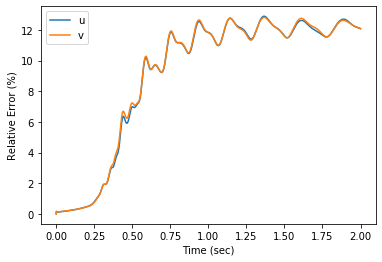


amp=0.93

Time elapsed: 232.01399326324463 sec
average relative error of u: 7.722397573729562%
average relative error of v: 7.75966963124997%
maximum relative error of u: 13.19359395154079%
maximum relative error of v: 13.127435859412723%
maximum relative error: 13.19359395154079%


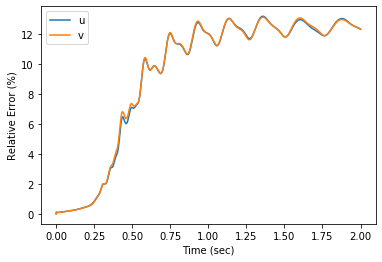


amp=0.94

Time elapsed: 229.55099534988403 sec
average relative error of u: 7.907000869037871%
average relative error of v: 7.940554586686161%
maximum relative error of u: 13.493451419719602%
maximum relative error of v: 13.439754099140613%
maximum relative error: 13.493451419719602%


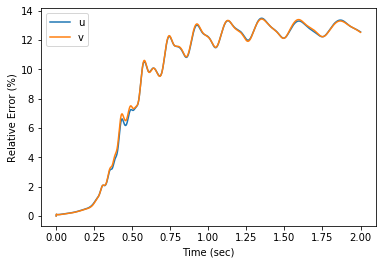


amp=0.95

Time elapsed: 231.03600120544434 sec
average relative error of u: 8.102616819386913%
average relative error of v: 8.132819392806894%
maximum relative error of u: 13.801177808401105%
maximum relative error of v: 13.758779102705788%
maximum relative error: 13.801177808401105%


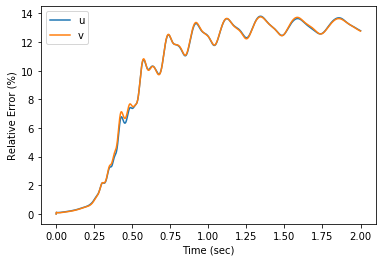


amp=0.96

Time elapsed: 228.93999814987183 sec
average relative error of u: 8.310439516024667%
average relative error of v: 8.337634258540067%
maximum relative error of u: 14.123861151992086%
maximum relative error of v: 14.091566476444168%
maximum relative error: 14.123861151992086%


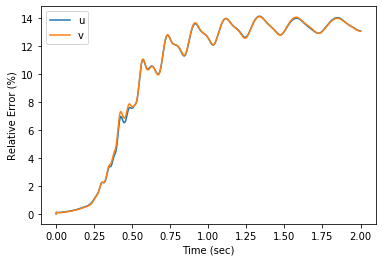


amp=0.97

Time elapsed: 227.73200058937073 sec
average relative error of u: 8.528087288318595%
average relative error of v: 8.552507694666241%
maximum relative error of u: 14.462117806369799%
maximum relative error of v: 14.438781925631282%
maximum relative error: 14.462117806369799%


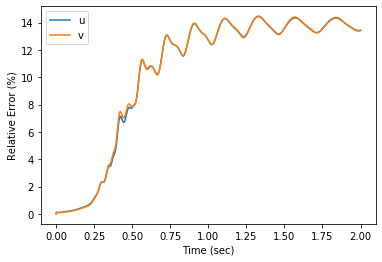


amp=0.98

Time elapsed: 228.79199838638306 sec
average relative error of u: 8.750997452952847%
average relative error of v: 8.7727005694419%
maximum relative error of u: 14.811970279695721%
maximum relative error of v: 14.796723477889262%
maximum relative error: 14.811970279695721%


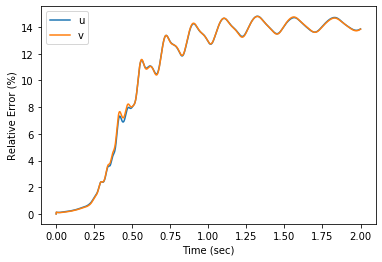


amp=0.99

Time elapsed: 226.5289967060089 sec
average relative error of u: 8.973899155265705%
average relative error of v: 8.992772673525112%
maximum relative error of u: 15.16723302150097%
maximum relative error of v: 15.15941712771831%
maximum relative error: 15.16723302150097%


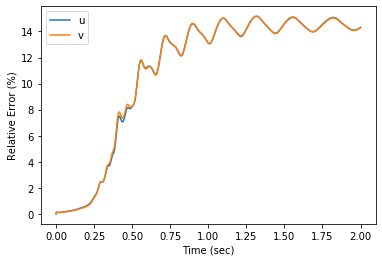


amp=1.0

Time elapsed: 226.74700021743774 sec
average relative error of u: 9.19162218045349%
average relative error of v: 9.207399994845343%
maximum relative error of u: 15.521100191077583%
maximum relative error of v: 15.52014412035935%
maximum relative error: 15.521100191077583%


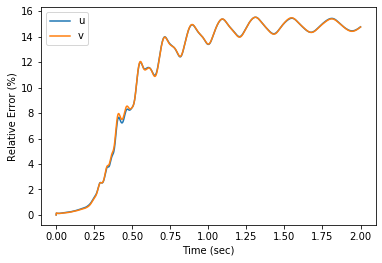


amp=1.01

Time elapsed: 221.1269989013672 sec
average relative error of u: 9.399666950882777%
average relative error of v: 9.412017555128982%
maximum relative error of u: 15.867165006349843%
maximum relative error of v: 15.87251103201269%
maximum relative error: 15.87251103201269%


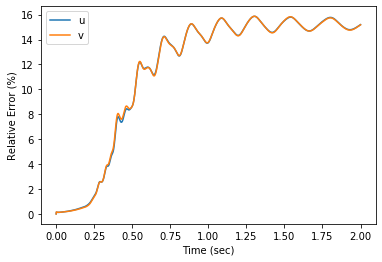


amp=1.02

Time elapsed: 225.77000045776367 sec
average relative error of u: 9.594637240906145%
average relative error of v: 9.603243401740865%
maximum relative error of u: 16.20000891225898%
maximum relative error of v: 16.211035943937535%
maximum relative error: 16.211035943937535%


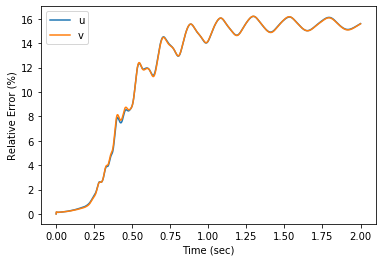


amp=1.03

Time elapsed: 227.49099779129028 sec
average relative error of u: 9.774566099309027%
average relative error of v: 9.779242581209346%
maximum relative error of u: 16.51562677905201%
maximum relative error of v: 16.531659157616705%
maximum relative error: 16.531659157616705%


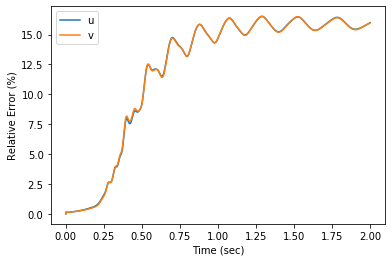


amp=1.04

Time elapsed: 225.99499797821045 sec
average relative error of u: 9.939162602983451%
average relative error of v: 9.93992235299299%
maximum relative error of u: 16.81173727113859%
maximum relative error of v: 16.83224371218825%
maximum relative error: 16.83224371218825%


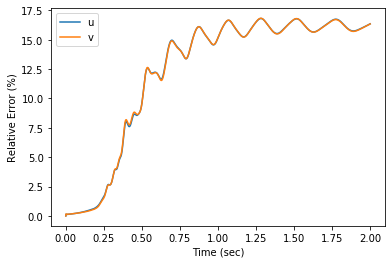


amp=1.05

Time elapsed: 222.9119963645935 sec
average relative error of u: 10.089562085360786%
average relative error of v: 10.086665925343281%
maximum relative error of u: 17.087481627169197%
maximum relative error of v: 17.11187397161784%
maximum relative error: 17.11187397161784%


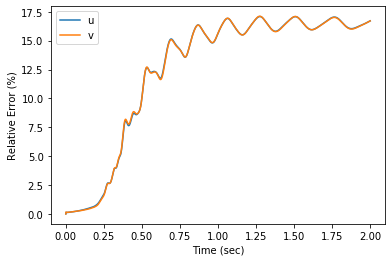


amp=1.06

Time elapsed: 230.3759961128235 sec
average relative error of u: 10.227567381553909%
average relative error of v: 10.221486144753037%
maximum relative error of u: 17.351402240082525%
maximum relative error of v: 17.370152517322886%
maximum relative error: 17.370152517322886%


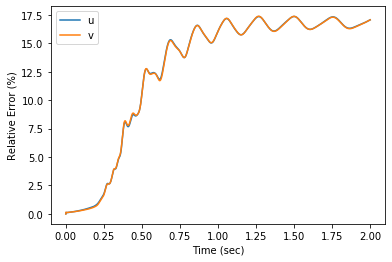


amp=1.07

Time elapsed: 229.23099899291992 sec
average relative error of u: 10.354809524467585%
average relative error of v: 10.346164539082693%
maximum relative error of u: 17.60377336053828%
maximum relative error of v: 17.608355950756565%
maximum relative error: 17.608355950756565%


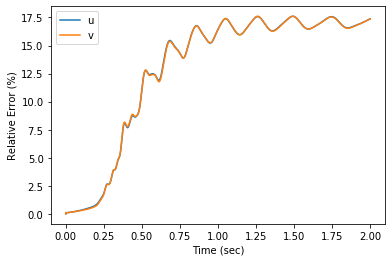


amp=1.08

Time elapsed: 227.85299968719482 sec
average relative error of u: 10.4721398851504%
average relative error of v: 10.461605942090584%
maximum relative error of u: 17.835268692609837%
maximum relative error of v: 17.836457760213882%
maximum relative error: 17.836457760213882%


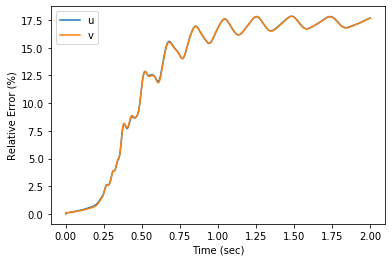


amp=1.09

Time elapsed: 226.68299889564514 sec
average relative error of u: 10.579306691224899%
average relative error of v: 10.567523222783747%
maximum relative error of u: 18.044042623876454%
maximum relative error of v: 18.041764552312898%
maximum relative error: 18.044042623876454%


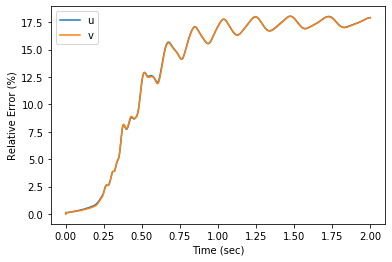


amp=1.1

Time elapsed: 214.51299738883972 sec
average relative error of u: 10.675056982339374%
average relative error of v: 10.662556965985523%
maximum relative error of u: 18.227850917996964%
maximum relative error of v: 18.221909915905943%
maximum relative error: 18.227850917996964%


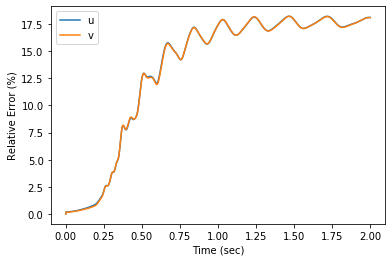


amp=1.11

Time elapsed: 183.28100156784058 sec
average relative error of u: 10.757074699293161%
average relative error of v: 10.744227262458962%
maximum relative error of u: 18.388508356282436%
maximum relative error of v: 18.373309847749383%
maximum relative error: 18.388508356282436%


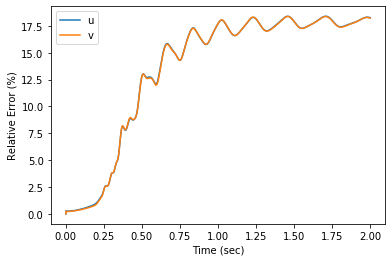


amp=1.12

Time elapsed: 178.7580006122589 sec
average relative error of u: 10.822189746514507%
average relative error of v: 10.809173434470448%
maximum relative error of u: 18.525200491863515%
maximum relative error of v: 18.495589978863908%
maximum relative error: 18.525200491863515%


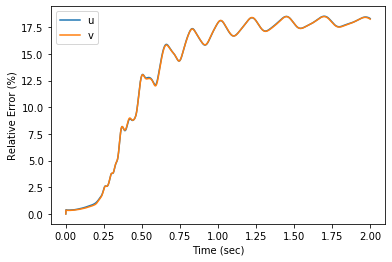


amp=1.13

Time elapsed: 180.90599918365479 sec
average relative error of u: 10.86647757611258%
average relative error of v: 10.853273347902753%
maximum relative error of u: 18.626195020276384%
maximum relative error of v: 18.593661069857234%
maximum relative error: 18.626195020276384%


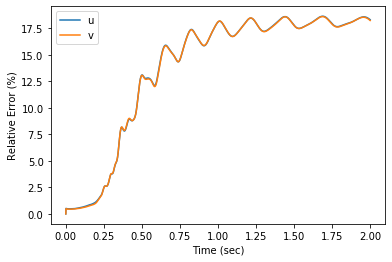


amp=1.14

Time elapsed: 182.7470006942749 sec
average relative error of u: 10.885691548130474%
average relative error of v: 10.872077295358906%
maximum relative error of u: 18.685392103343563%
maximum relative error of v: 18.64869444935636%
maximum relative error: 18.685392103343563%


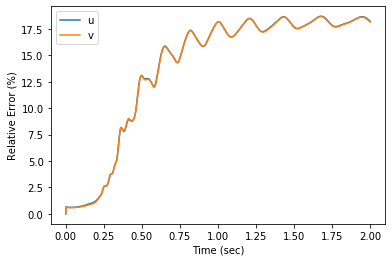


amp=1.15

Time elapsed: 185.7109980583191 sec
average relative error of u: 10.875309960351222%
average relative error of v: 10.860874095811049%
maximum relative error of u: 18.69590881439467%
maximum relative error of v: 18.653618160269346%
maximum relative error: 18.69590881439467%


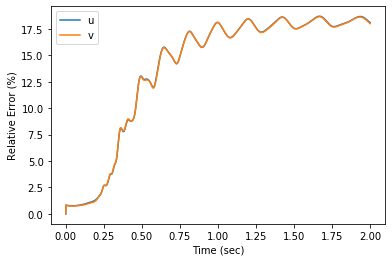

In [10]:
ampArr=np.array([0.85,0.86,0.87,0.88,0.89,0.9,0.91,0.92,0.93,0.94,0.95,0.96,0.97,0.98,0.99,1.0,\
                 1.01,1.02,1.03,1.04,1.05,1.06,1.07,1.08,1.09,1.1,1.11,1.12,1.13,1.14,1.15])
namp=ampArr.shape[0]
resultArrGalerkin=np.zeros((namp,7))

for iii in range(namp):
    # load full order solution
    amp=ampArr[iii]
    print()
    print('amp={}'.format(amp))
    if Re==10000:
        file_name_FOM="./data/FOM_high_Re_amp_{}.p".format(amp)
    elif Re==100:
        file_name_FOM="./data/FOM_low_Re_amp_{}.p".format(amp)
    else:
        raise NameError('{} is given for Re, but it must be either 100 or 10000'.format(Re))
    
    FOM_solution=pickle.load(open(file_name_FOM,'rb'))   
    u_full=FOM_solution['u']
    v_full=FOM_solution['v']
    
    # IC
    u0=u_full[0]
    v0=v_full[0]
    
    # boundary for first order derivative term
    Bdudx0_cur=np.kron(u0[x0_raveled_indicies],x0_one_hot)
    Bdudy0_cur=np.kron(y0_one_hot,u0[y0_raveled_indicies])
    Bdvdx0_cur=np.kron(v0[x0_raveled_indicies],x0_one_hot)
    Bdvdy0_cur=np.kron(y0_one_hot,v0[y0_raveled_indicies])
    Bdudx1_cur=np.kron(u0[x1_raveled_indicies],x1_one_hot)
    Bdudy1_cur=np.kron(y1_one_hot,u0[y1_raveled_indicies])
    Bdvdx1_cur=np.kron(v0[x1_raveled_indicies],x1_one_hot)
    Bdvdy1_cur=np.kron(y1_one_hot,v0[y1_raveled_indicies])

    # boundary for second order derivative term
    bxu_cur=np.zeros(nxy)
    byu_cur=np.zeros(nxy)
    bxv_cur=np.zeros(nxy)
    byv_cur=np.zeros(nxy)

    bxu_cur[inner_x_raveled_indicies]=u0[x01_raveled_indicies]
    byu_cur[inner_y_raveled_indicies]=u0[y01_raveled_indicies]
    bxv_cur[inner_x_raveled_indicies]=v0[x01_raveled_indicies]
    byv_cur[inner_y_raveled_indicies]=v0[y01_raveled_indicies]
    
    # precompute terms
    au1_cur=(-1/dx*u_ref*(Mu_ref-Bdudx0_cur)-1/dy*v_ref*(Nu_ref-Bdudy0_cur) \
    +1/(Re*dx**2)*(Dxu_ref+bxu_cur)+1/(Re*dy**2)*(Dyu_ref+byu_cur)).astype('float32')
    Au2_cur=(-1/dx*(sp.diags(u_ref,format='csr').dot(M)+sp.diags(Mu_ref-Bdudx0_cur,format='csr')) \
    -1/dy*sp.diags(v_ref,format='csr').dot(N) \
    +1/(Re*dx**2)*Dx+1/(Re*dy**2)*Dy).astype('float32')
    au3_cur=(-1/dy*(Nu_ref-Bdudy0_cur)).astype('float32')

    av1_cur=(-1/dx*u_ref*(Mv_ref-Bdvdx0_cur)-1/dy*v_ref*(Nv_ref-Bdvdy0_cur) \
    +1/(Re*dx**2)*(Dxv_ref+bxv_cur)+1/(Re*dy**2)*(Dyv_ref+byv_cur)).astype('float32')
    av2_cur=(-1/dx*(Mv_ref-Bdvdx0_cur)).astype('float32')
    Av3_cur=(-1/dx*sp.diags(u_ref,format='csr').dot(M) \
    -1/dy*(sp.diags(v_ref,format='csr').dot(N)+sp.diags(Nv_ref-Bdvdy0_cur,format='csr')) \
    +1/(Re*dx**2)*Dx+1/(Re*dy**2)*Dy).astype('float32')

    Au2T_cur=Au2_cur.T
    Av3T_cur=Av3_cur.T
    
    # set parameters
    I_hat=np.eye(latent_dim,dtype='float32')

    maxitr=4
    tol=1e-6

    # IC for reduced state
    u_hat0=encoder_u_np_forward(u0[free_raveled_indicies].astype('float32')-u_ref)
    v_hat0=encoder_v_np_forward(v0[free_raveled_indicies].astype('float32')-v_ref)
    
    # Run ROM
    t_start_g=time.time()

    # solution
    u_reduced=np.zeros((nt+1,latent_dim))
    v_reduced=np.zeros((nt+1,latent_dim))
    u_rom_g=np.zeros((nt+1,ny*nx))
    v_rom_g=np.zeros((nt+1,ny*nx))

    # IC
    u_reduced[0]=np.copy(u_hat0)
    v_reduced[0]=np.copy(v_hat0)
    u_rom_g[0]=np.copy(u0)
    v_rom_g[0]=np.copy(v0)

    for k in range(nt):
    #     print("")
    #     print(k,"th time step:")

        u_hat_prev=np.copy(u_reduced[k])
        v_hat_prev=np.copy(v_reduced[k])

        u_hat=np.copy(u_reduced[k])
        v_hat=np.copy(v_reduced[k])

        g_u,Jg_uT=decoder_u_sp_forward_backwardT(u_hat)
        g_v,Jg_vT=decoder_v_sp_forward_backwardT(v_hat)

        Jg_uT_pinv=np.linalg.pinv(Jg_uT)
        Jg_vT_pinv=np.linalg.pinv(Jg_vT)

        Mg_u=M.dot(g_u)
        Ng_u=N.dot(g_u)
        Mg_v=M.dot(g_v)
        Ng_v=N.dot(g_v)

        Jg_uTMT=sp.csc_matrix.dot(Jg_uT,MT)
        Jg_uTNT=sp.csc_matrix.dot(Jg_uT,NT)
        Jg_vTMT=sp.csc_matrix.dot(Jg_vT,MT)
        Jg_vTNT=sp.csc_matrix.dot(Jg_vT,NT)

        residual_hat=r_hat(u_hat,v_hat,u_hat_prev,v_hat_prev,g_u,g_v,Mg_u,Ng_u,Mg_v,Ng_v,Jg_uT_pinv,Jg_vT_pinv,\
                           au1_cur,Au2_cur,au3_cur,av1_cur,av2_cur,Av3_cur)

        for itr in range(maxitr):
            Jacobian_hat=J_hat(g_u,g_v,Mg_u,Ng_u,Mg_v,Ng_v,Jg_uT,Jg_vT,Jg_uTMT,Jg_uTNT,Jg_vTMT,Jg_vTNT)

            delta_reduced=np.linalg.solve(Jacobian_hat,-residual_hat)

            u_hat+=delta_reduced[:latent_dim]
            v_hat+=delta_reduced[latent_dim:]

            g_u,Jg_uT=decoder_u_sp_forward_backwardT(u_hat)
            g_v,Jg_vT=decoder_v_sp_forward_backwardT(v_hat)

            Jg_uT_pinv=np.linalg.pinv(Jg_uT)
            Jg_vT_pinv=np.linalg.pinv(Jg_vT)

            Mg_u=M.dot(g_u)
            Ng_u=N.dot(g_u)
            Mg_v=M.dot(g_v)
            Ng_v=N.dot(g_v)

            Jg_uTMT=sp.csc_matrix.dot(Jg_uT,MT)
            Jg_uTNT=sp.csc_matrix.dot(Jg_uT,NT)
            Jg_vTMT=sp.csc_matrix.dot(Jg_vT,MT)
            Jg_vTNT=sp.csc_matrix.dot(Jg_vT,NT)

            residual_hat=r_hat(u_hat,v_hat,u_hat_prev,v_hat_prev,g_u,g_v,Mg_u,Ng_u,Mg_v,Ng_v,Jg_uT_pinv,Jg_vT_pinv,\
                               au1_cur,Au2_cur,au3_cur,av1_cur,av2_cur,Av3_cur)

            R=np.linalg.norm(residual_hat)
    #         print(itr,"th Newton iteration", "R:", "{:.8e}".format(R))

            if R<tol:
                u_reduced[k+1]=u_hat.copy()
                v_reduced[k+1]=v_hat.copy()
                u_rom_g[k+1,free_raveled_indicies]=u_ref+decoder_u_sp_forward(u_hat)
                v_rom_g[k+1,free_raveled_indicies]=v_ref+decoder_v_sp_forward(v_hat)
                # BC from exact solution
                u_rom_g[k+1,fixed_raveled_indicies]=u0[fixed_raveled_indicies].copy()
                v_rom_g[k+1,fixed_raveled_indicies]=v0[fixed_raveled_indicies].copy()
                break

        if R>=tol:
    #         print("\n non converged after {}th iteration".format(maxitr))
#             break  
            u_reduced[k+1]=u_hat.copy()
            v_reduced[k+1]=v_hat.copy()
            u_rom_g[k+1,free_raveled_indicies]=u_ref+decoder_u_sp_forward(u_hat)
            v_rom_g[k+1,free_raveled_indicies]=v_ref+decoder_v_sp_forward(v_hat)
            # BC from exact solution
            u_rom_g[k+1,fixed_raveled_indicies]=u0[fixed_raveled_indicies].copy()
            v_rom_g[k+1,fixed_raveled_indicies]=v0[fixed_raveled_indicies].copy()

#         u_reduced[k+1]=u_hat.copy()
#         v_reduced[k+1]=v_hat.copy()
#         u_rom_g[k+1,free_raveled_indicies]=u_ref+decoder_u_sp_forward(u_hat)
#         v_rom_g[k+1,free_raveled_indicies]=v_ref+decoder_v_sp_forward(v_hat)
#         # BC from exact solution
#         u_rom_g[k+1,fixed_raveled_indicies]=u0[fixed_raveled_indicies].copy()
#         v_rom_g[k+1,fixed_raveled_indicies]=v0[fixed_raveled_indicies].copy()

    t_elapsed_g=time.time()-t_start_g
    print()
    print('Time elapsed: {} sec'.format(t_elapsed_g))

    # compute errors
    u_rel_err=np.linalg.norm(u_full-u_rom_g,ord=2,axis=1)/np.linalg.norm(u_full,ord=2,axis=1)*100
    v_rel_err=np.linalg.norm(v_full-v_rom_g,ord=2,axis=1)/np.linalg.norm(v_full,ord=2,axis=1)*100

    u_avg_rel_err=np.sqrt(np.sum(np.linalg.norm(u_full-u_rom_g,ord=2,axis=1)**2))/np.sqrt(np.sum(np.linalg.norm(u_full,ord=2,axis=1)**2))*100
    v_avg_rel_err=np.sqrt(np.sum(np.linalg.norm(v_full-v_rom_g,ord=2,axis=1)**2))/np.sqrt(np.sum(np.linalg.norm(v_full,ord=2,axis=1)**2))*100

    u_max_rel_err=np.max(u_rel_err)
    v_max_rel_err=np.max(v_rel_err)

    max_rel_err=np.maximum(u_max_rel_err,v_max_rel_err)

    print("average relative error of u: {}%".format(u_avg_rel_err))
    print("average relative error of v: {}%".format(v_avg_rel_err))
    print("maximum relative error of u: {}%".format(u_max_rel_err))
    print("maximum relative error of v: {}%".format(v_max_rel_err))
    print("maximum relative error: {}%".format(max_rel_err))

    plt.plot(dt*np.arange(nt+1),u_rel_err,dt*np.arange(nt+1),v_rel_err)
    plt.xlabel('Time (sec)')
    plt.ylabel('Relative Error (%)')
    plt.legend(('u','v'))
    plt.show()

    # save results
    resultArrGalerkin[iii]=[amp,t_elapsed_g,u_avg_rel_err,v_avg_rel_err,u_max_rel_err,v_max_rel_err,max_rel_err] 

# LSPG

In [11]:
def theta_u(g_u,g_v,Mg_u,Ng_u):
    return -1/dx*g_u*Mg_u-1/dy*g_v*Ng_u

def theta_v(g_u,g_v,Mg_v,Ng_v):
    return -1/dx*g_u*Mg_v-1/dy*g_v*Ng_v

def dtheta_udu_hatT(g_u,g_v,Mg_u,Jg_uT,Jg_uTMT,Jg_uTNT):
    return -1/dx*(Mg_u*Jg_uT+g_u*Jg_uTMT)-1/dy*g_v*Jg_uTNT

def dtheta_udv_hatT(Ng_u,Jg_vT):
    return -1/dy*Ng_u*Jg_vT

def dtheta_vdu_hatT(Mg_v,Jg_uT):
    return -1/dx*Mg_v*Jg_uT

def dtheta_vdv_hatT(g_u,g_v,Ng_v,Jg_vT,Jg_vTMT,Jg_vTNT):
    return -1/dx*g_u*Jg_vTMT-1/dy*(Ng_v*Jg_vT+g_v*Jg_vTNT)

def r_tilde(g_u,g_v,g_u_prev,g_v_prev,Mg_u,Ng_u,Mg_v,Ng_v,\
            au1_cur,Au2_cur,au3_cur,av1_cur,av2_cur,Av3_cur):
    r_u=g_u-g_u_prev-dt*(au1_cur+Au2_cur.dot(g_u)+au3_cur*g_v+theta_u(g_u,g_v,Mg_u,Ng_u))
    r_v=g_v-g_v_prev-dt*(av1_cur+av2_cur*g_u+Av3_cur.dot(g_v)+theta_v(g_u,g_v,Mg_v,Ng_v))
    return np.concatenate((r_u,r_v))

def J_tildeT(g_u,g_v,Mg_u,Ng_u,Mg_v,Ng_v,Jg_uT,Jg_vT,Jg_uTMT,Jg_uTNT,Jg_vTMT,Jg_vTNT,\
            Au2T_cur,au3_cur,av2_cur,Av3T_cur):
    J11T=Jg_uT-dt*(sp.csc_matrix.dot(Jg_uT,Au2T_cur)+dtheta_udu_hatT(g_u,g_v,Mg_u,Jg_uT,Jg_uTMT,Jg_uTNT))
    J12T=-dt*(au3_cur*Jg_vT+dtheta_udv_hatT(Ng_u,Jg_vT))
    J21T=-dt*(av2_cur*Jg_uT+dtheta_vdu_hatT(Mg_v,Jg_uT))
    J22T=Jg_vT-dt*(sp.csc_matrix.dot(Jg_vT,Av3T_cur)+dtheta_vdv_hatT(g_u,g_v,Ng_v,Jg_vT,Jg_vTMT,Jg_vTNT))
    return np.block([[J11T,J21T],[J12T,J22T]])


amp=0.85

Time elapsed: 107.9499990940094 sec
average relative error of u: 1.400065935897905%
average relative error of v: 1.4537441941717715%
maximum relative error of u: 2.573338517785715%
maximum relative error of v: 2.6745287535956144%
maximum relative error: 2.6745287535956144%


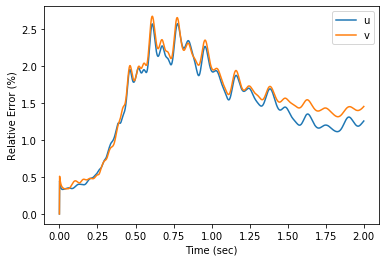


amp=0.86

Time elapsed: 102.52900052070618 sec
average relative error of u: 1.4988115095183898%
average relative error of v: 1.5261733014816359%
maximum relative error of u: 2.7584690273681116%
maximum relative error of v: 2.820374290234709%
maximum relative error: 2.820374290234709%


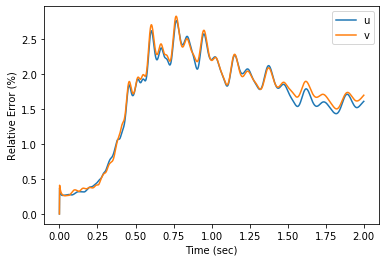


amp=0.87

Time elapsed: 103.02900052070618 sec
average relative error of u: 1.4882744121189715%
average relative error of v: 1.5026624996843592%
maximum relative error of u: 2.7104331244052577%
maximum relative error of v: 2.7589919500673514%
maximum relative error: 2.7589919500673514%


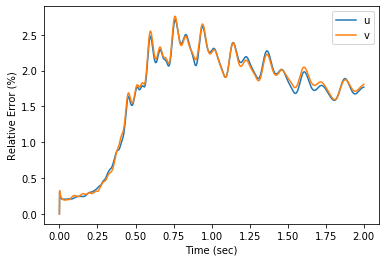


amp=0.88

Time elapsed: 106.65900039672852 sec
average relative error of u: 1.3809007264921103%
average relative error of v: 1.3893431007103247%
maximum relative error of u: 2.4889300926521356%
maximum relative error of v: 2.527704375668155%
maximum relative error: 2.527704375668155%


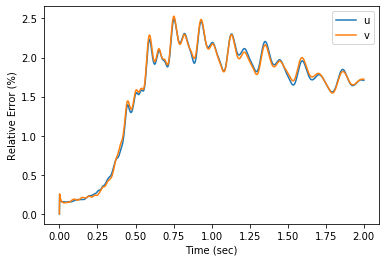


amp=0.89

Time elapsed: 101.87100076675415 sec
average relative error of u: 1.2094292769571156%
average relative error of v: 1.2154126626554413%
maximum relative error of u: 2.1815907461539%
maximum relative error of v: 2.1980988951218037%
maximum relative error: 2.1980988951218037%


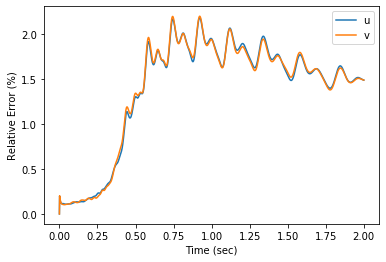


amp=0.9

Time elapsed: 101.7340018749237 sec
average relative error of u: 1.0108677189094832%
average relative error of v: 1.0158376306912429%
maximum relative error of u: 1.8471519212814325%
maximum relative error of v: 1.856363487686579%
maximum relative error: 1.856363487686579%


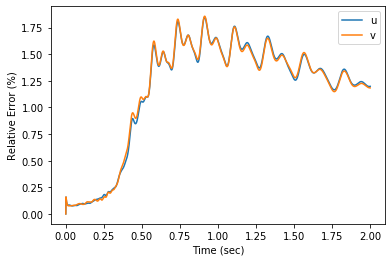


amp=0.91

Time elapsed: 103.31699967384338 sec
average relative error of u: 0.8170872198830963%
average relative error of v: 0.821353825750833%
maximum relative error of u: 1.5143118132884938%
maximum relative error of v: 1.5163356062711328%
maximum relative error: 1.5163356062711328%


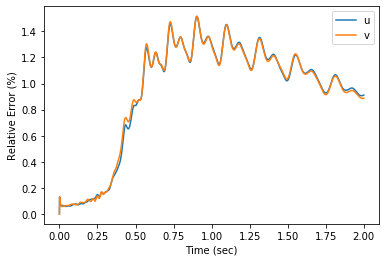


amp=0.92

Time elapsed: 105.69799733161926 sec
average relative error of u: 0.6463007662635111%
average relative error of v: 0.6496591797590924%
maximum relative error of u: 1.2152783687162232%
maximum relative error of v: 1.2107571643159514%
maximum relative error: 1.2152783687162232%


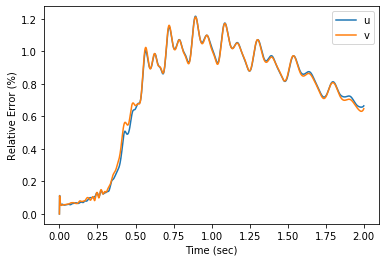


amp=0.93

Time elapsed: 109.32599663734436 sec
average relative error of u: 0.5067149597419971%
average relative error of v: 0.5087498908146681%
maximum relative error of u: 0.9629721859963828%
maximum relative error of v: 0.9526088349411318%
maximum relative error: 0.9629721859963828%


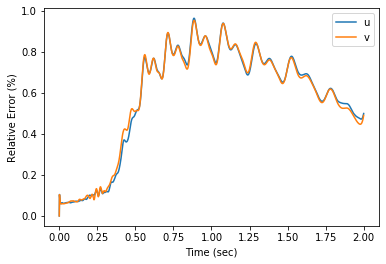


amp=0.94

Time elapsed: 106.43000078201294 sec
average relative error of u: 0.39536086288900146%
average relative error of v: 0.3957607168392197%
maximum relative error of u: 0.7540536008059647%
maximum relative error of v: 0.7465043699562783%
maximum relative error: 0.7540536008059647%


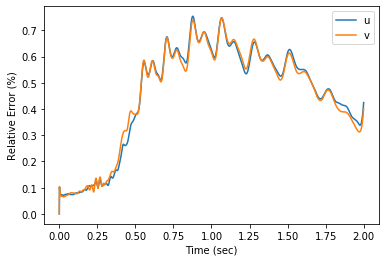


amp=0.95

Time elapsed: 107.75800085067749 sec
average relative error of u: 0.3068171617747457%
average relative error of v: 0.3055356654105236%
maximum relative error of u: 0.586953580841169%
maximum relative error of v: 0.5855400779748194%
maximum relative error: 0.586953580841169%


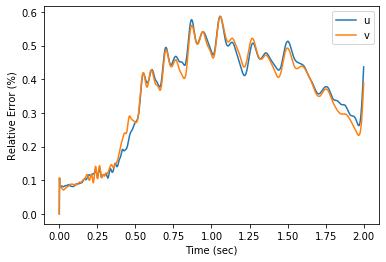


amp=0.96

Time elapsed: 108.15000057220459 sec
average relative error of u: 0.23298742320758975%
average relative error of v: 0.2305112636191333%
maximum relative error of u: 0.48715263667090763%
maximum relative error of v: 0.43704828077890046%
maximum relative error: 0.48715263667090763%


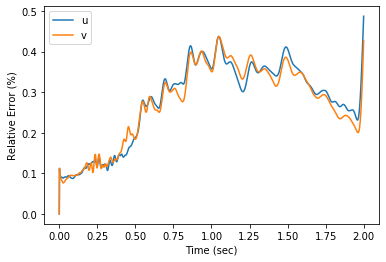


amp=0.97

Time elapsed: 107.98900055885315 sec
average relative error of u: 0.1728736572632559%
average relative error of v: 0.17071935012039297%
maximum relative error of u: 0.5398015759125084%
maximum relative error of v: 0.4882617498791206%
maximum relative error: 0.5398015759125084%


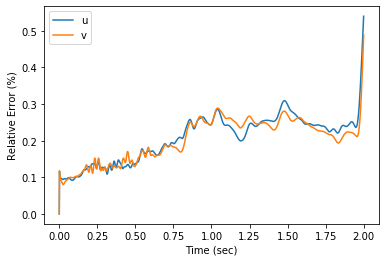


amp=0.98

Time elapsed: 105.88200211524963 sec
average relative error of u: 0.1519524904248662%
average relative error of v: 0.1533637521733031%
maximum relative error of u: 0.5888404434280279%
maximum relative error of v: 0.5649327691291538%
maximum relative error: 0.5888404434280279%


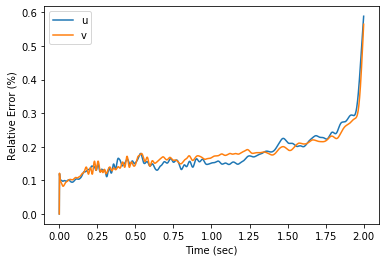


amp=0.99

Time elapsed: 101.01899719238281 sec
average relative error of u: 0.21322927606954087%
average relative error of v: 0.21852226086284976%
maximum relative error of u: 0.6543302769389107%
maximum relative error of v: 0.6640583590530094%
maximum relative error: 0.6640583590530094%


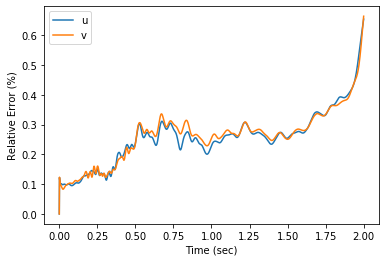


amp=1.0

Time elapsed: 103.51799845695496 sec
average relative error of u: 0.34357052718991776%
average relative error of v: 0.3501944487911386%
maximum relative error of u: 0.7721594620140609%
maximum relative error of v: 0.7959531476791201%
maximum relative error: 0.7959531476791201%


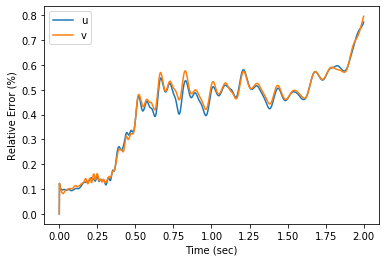


amp=1.01

Time elapsed: 103.21000027656555 sec
average relative error of u: 0.518828630372277%
average relative error of v: 0.5254635712281696%
maximum relative error of u: 1.0011215677407828%
maximum relative error of v: 1.0061520189505428%
maximum relative error: 1.0061520189505428%


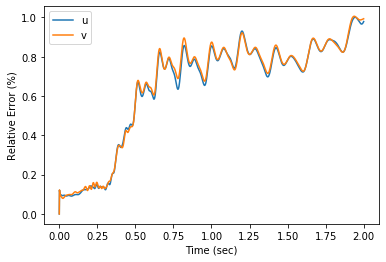


amp=1.02

Time elapsed: 105.7680013179779 sec
average relative error of u: 0.7300195015610356%
average relative error of v: 0.7359524938208126%
maximum relative error of u: 1.3814808671909324%
maximum relative error of v: 1.3957080270986972%
maximum relative error: 1.3957080270986972%


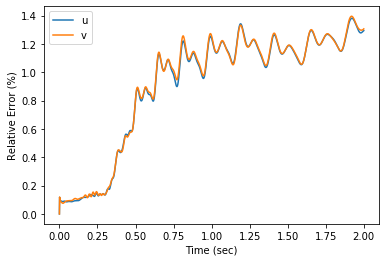


amp=1.03

Time elapsed: 101.8999981880188 sec
average relative error of u: 0.971790938240014%
average relative error of v: 0.9765869321588625%
maximum relative error of u: 1.8562043444878293%
maximum relative error of v: 1.8703380275108155%
maximum relative error: 1.8703380275108155%


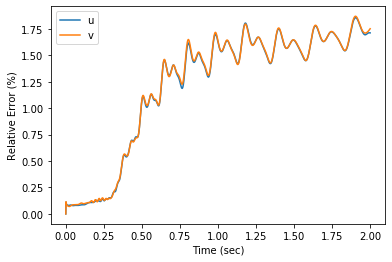


amp=1.04

Time elapsed: 104.79099822044373 sec
average relative error of u: 1.2407785836819265%
average relative error of v: 1.2441323146858296%
maximum relative error of u: 2.4160341005686923%
maximum relative error of v: 2.4257859712054235%
maximum relative error: 2.4257859712054235%


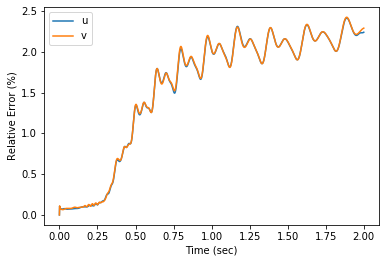


amp=1.05

Time elapsed: 103.29099726676941 sec
average relative error of u: 1.5356778474742105%
average relative error of v: 1.5373089079186142%
maximum relative error of u: 3.0449911128535447%
maximum relative error of v: 3.0474021366365607%
maximum relative error: 3.0474021366365607%


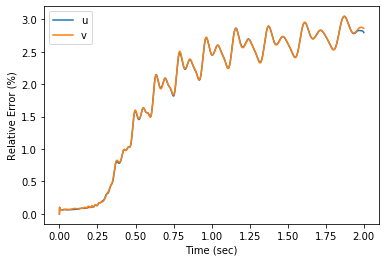


amp=1.06

Time elapsed: 105.03600025177002 sec
average relative error of u: 1.8585188828644454%
average relative error of v: 1.8586100540888009%
maximum relative error of u: 3.7520177167174684%
maximum relative error of v: 3.7444715696085242%
maximum relative error: 3.7520177167174684%


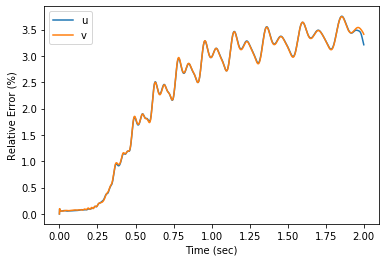


amp=1.07

Time elapsed: 104.1569972038269 sec
average relative error of u: 2.2119928969806373%
average relative error of v: 2.2107643349285833%
maximum relative error of u: 4.52538839113504%
maximum relative error of v: 4.505424575783793%
maximum relative error: 4.52538839113504%


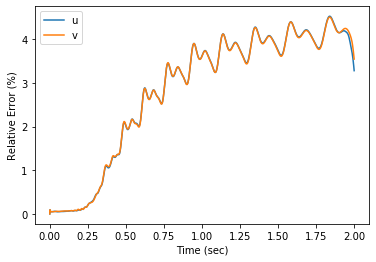


amp=1.08

Time elapsed: 108.23699879646301 sec
average relative error of u: 2.6015791431095443%
average relative error of v: 2.5987543523549506%
maximum relative error of u: 5.374338070637758%
maximum relative error of v: 5.339822293944745%
maximum relative error: 5.374338070637758%


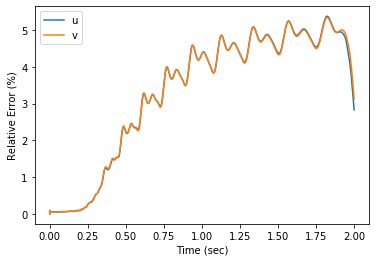


amp=1.09

Time elapsed: 105.04699969291687 sec
average relative error of u: 3.034378949710052%
average relative error of v: 3.0292708877496874%
maximum relative error of u: 6.279224888603273%
maximum relative error of v: 6.229787460667522%
maximum relative error: 6.279224888603273%


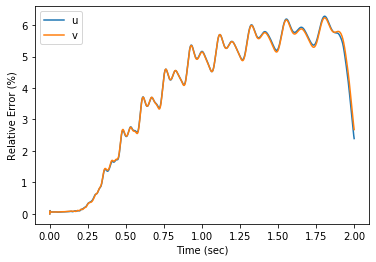


amp=1.1

Time elapsed: 112.79099559783936 sec
average relative error of u: 3.525111782142512%
average relative error of v: 3.5165534047785703%
maximum relative error of u: 7.276011003677818%
maximum relative error of v: 7.213847946052314%
maximum relative error: 7.276011003677818%


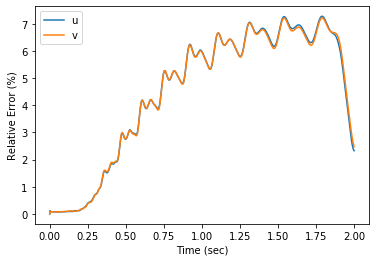


amp=1.11

Time elapsed: 107.50600028038025 sec
average relative error of u: 4.0851720916680465%
average relative error of v: 4.071756990200935%
maximum relative error of u: 8.47924808806735%
maximum relative error of v: 8.384706741436178%
maximum relative error: 8.47924808806735%


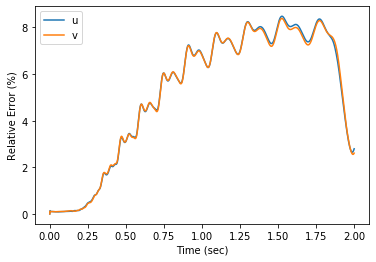


amp=1.12

Time elapsed: 111.35699844360352 sec
average relative error of u: 4.719265540208292%
average relative error of v: 4.700770460697829%
maximum relative error of u: 9.832892195385549%
maximum relative error of v: 9.679358282235256%
maximum relative error: 9.832892195385549%


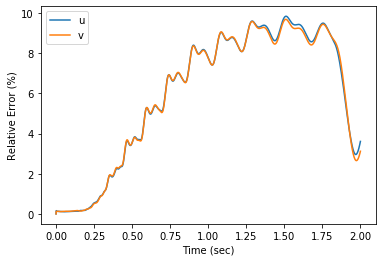


amp=1.13

Time elapsed: 116.78000235557556 sec
average relative error of u: 5.4266341813021395%
average relative error of v: 5.404487427270252%
maximum relative error of u: 11.309895466667832%
maximum relative error of v: 11.08302109980722%
maximum relative error: 11.309895466667832%


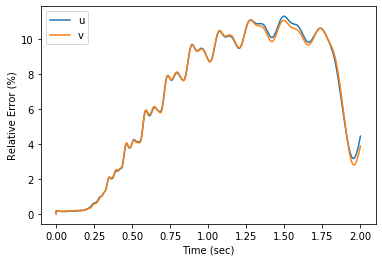


amp=1.14

Time elapsed: 109.98499631881714 sec
average relative error of u: 6.196999873687112%
average relative error of v: 6.17379263319201%
maximum relative error of u: 12.862565077130238%
maximum relative error of v: 12.725393551166453%
maximum relative error: 12.862565077130238%


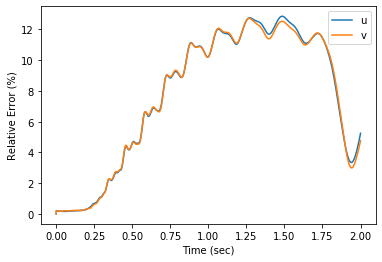


amp=1.15

Time elapsed: 116.34099912643433 sec
average relative error of u: 7.008330646969179%
average relative error of v: 6.9874602426064065%
maximum relative error of u: 14.512825242090202%
maximum relative error of v: 14.42943329786982%
maximum relative error: 14.512825242090202%


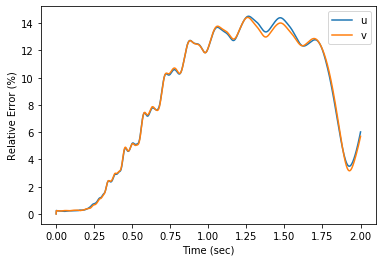

In [12]:
ampArr=np.array([0.85,0.86,0.87,0.88,0.89,0.9,0.91,0.92,0.93,0.94,0.95,0.96,0.97,0.98,0.99,1.0,\
                 1.01,1.02,1.03,1.04,1.05,1.06,1.07,1.08,1.09,1.1,1.11,1.12,1.13,1.14,1.15])
namp=ampArr.shape[0]
resultArrLSPG=np.zeros((namp,7))

for iii in range(namp):
    # load full order solution
    amp=ampArr[iii]
    print()
    print('amp={}'.format(amp))
    if Re==10000:
        file_name_FOM="./data/FOM_high_Re_amp_{}.p".format(amp)
    elif Re==100:
        file_name_FOM="./data/FOM_low_Re_amp_{}.p".format(amp)
    else:
        raise NameError('{} is given for Re, but it must be either 100 or 10000'.format(Re))
    
    FOM_solution=pickle.load(open(file_name_FOM,'rb'))   
    u_full=FOM_solution['u']
    v_full=FOM_solution['v']
    
    # IC
    u0=u_full[0]
    v0=v_full[0]
    
    # boundary for first order derivative term
    Bdudx0_cur=np.kron(u0[x0_raveled_indicies],x0_one_hot)
    Bdudy0_cur=np.kron(y0_one_hot,u0[y0_raveled_indicies])
    Bdvdx0_cur=np.kron(v0[x0_raveled_indicies],x0_one_hot)
    Bdvdy0_cur=np.kron(y0_one_hot,v0[y0_raveled_indicies])
    Bdudx1_cur=np.kron(u0[x1_raveled_indicies],x1_one_hot)
    Bdudy1_cur=np.kron(y1_one_hot,u0[y1_raveled_indicies])
    Bdvdx1_cur=np.kron(v0[x1_raveled_indicies],x1_one_hot)
    Bdvdy1_cur=np.kron(y1_one_hot,v0[y1_raveled_indicies])

    # boundary for second order derivative term
    bxu_cur=np.zeros(nxy)
    byu_cur=np.zeros(nxy)
    bxv_cur=np.zeros(nxy)
    byv_cur=np.zeros(nxy)

    bxu_cur[inner_x_raveled_indicies]=u0[x01_raveled_indicies]
    byu_cur[inner_y_raveled_indicies]=u0[y01_raveled_indicies]
    bxv_cur[inner_x_raveled_indicies]=v0[x01_raveled_indicies]
    byv_cur[inner_y_raveled_indicies]=v0[y01_raveled_indicies]
    
    # precompute terms
    au1_cur=(-1/dx*u_ref*(Mu_ref-Bdudx0_cur)-1/dy*v_ref*(Nu_ref-Bdudy0_cur) \
    +1/(Re*dx**2)*(Dxu_ref+bxu_cur)+1/(Re*dy**2)*(Dyu_ref+byu_cur)).astype('float32')
    Au2_cur=(-1/dx*(sp.diags(u_ref,format='csr').dot(M)+sp.diags(Mu_ref-Bdudx0_cur,format='csr')) \
    -1/dy*sp.diags(v_ref,format='csr').dot(N) \
    +1/(Re*dx**2)*Dx+1/(Re*dy**2)*Dy).astype('float32')
    au3_cur=(-1/dy*(Nu_ref-Bdudy0_cur)).astype('float32')

    av1_cur=(-1/dx*u_ref*(Mv_ref-Bdvdx0_cur)-1/dy*v_ref*(Nv_ref-Bdvdy0_cur) \
    +1/(Re*dx**2)*(Dxv_ref+bxv_cur)+1/(Re*dy**2)*(Dyv_ref+byv_cur)).astype('float32')
    av2_cur=(-1/dx*(Mv_ref-Bdvdx0_cur)).astype('float32')
    Av3_cur=(-1/dx*sp.diags(u_ref,format='csr').dot(M) \
    -1/dy*(sp.diags(v_ref,format='csr').dot(N)+sp.diags(Nv_ref-Bdvdy0_cur,format='csr')) \
    +1/(Re*dx**2)*Dx+1/(Re*dy**2)*Dy).astype('float32')

    Au2T_cur=Au2_cur.T
    Av3T_cur=Av3_cur.T
    
    # set parameters
    I_hat=np.eye(latent_dim,dtype='float32')

    maxitr=4
    tol=1e-6

    # IC for reduced state
    u_hat0=encoder_u_np_forward(u0[free_raveled_indicies].astype('float32')-u_ref)
    v_hat0=encoder_v_np_forward(v0[free_raveled_indicies].astype('float32')-v_ref)
    
    # Run ROM
    t_start_pg=time.time()

    # solution
    u_reduced=np.zeros((nt+1,latent_dim))
    v_reduced=np.zeros((nt+1,latent_dim))
    u_rom_pg=np.zeros((nt+1,ny*nx))
    v_rom_pg=np.zeros((nt+1,ny*nx))

    # IC
    u_reduced[0]=np.copy(u_hat0)
    v_reduced[0]=np.copy(v_hat0)
    u_rom_pg[0]=np.copy(u0)
    v_rom_pg[0]=np.copy(v0)

    for k in range(nt):
    #     print("")
    #     print(k,"th time step:")

        u_hat_prev=np.copy(u_reduced[k])
        v_hat_prev=np.copy(v_reduced[k])

        g_u_prev=u_rom_pg[k,free_raveled_indicies]-u_ref
        g_v_prev=v_rom_pg[k,free_raveled_indicies]-v_ref

        u_hat=np.copy(u_reduced[k])
        v_hat=np.copy(v_reduced[k])

        g_u,Jg_uT=decoder_u_sp_forward_backwardT(u_hat)
        g_v,Jg_vT=decoder_v_sp_forward_backwardT(v_hat)

        Mg_u=M.dot(g_u)
        Ng_u=N.dot(g_u)
        Mg_v=M.dot(g_v)
        Ng_v=N.dot(g_v)

        Jg_uTMT=sp.csc_matrix.dot(Jg_uT,MT)
        Jg_uTNT=sp.csc_matrix.dot(Jg_uT,NT)
        Jg_vTMT=sp.csc_matrix.dot(Jg_vT,MT)
        Jg_vTNT=sp.csc_matrix.dot(Jg_vT,NT)

        residual_tilde=r_tilde(g_u,g_v,g_u_prev,g_v_prev,Mg_u,Ng_u,Mg_v,Ng_v,\
                               au1_cur,Au2_cur,au3_cur,av1_cur,av2_cur,Av3_cur)
        Jacobian_tildeT=J_tildeT(g_u,g_v,Mg_u,Ng_u,Mg_v,Ng_v,Jg_uT,Jg_vT,Jg_uTMT,Jg_uTNT,Jg_vTMT,Jg_vTNT,\
                                 Au2T_cur,au3_cur,av2_cur,Av3T_cur)
        residual_hat=Jacobian_tildeT.dot(residual_tilde)

        for itr in range(maxitr):
            Jacobian_hat=Jacobian_tildeT.dot(Jacobian_tildeT.T)

            delta_reduced=np.linalg.solve(Jacobian_hat,-residual_hat)

            u_hat+=delta_reduced[:latent_dim]
            v_hat+=delta_reduced[latent_dim:]

            g_u,Jg_uT=decoder_u_sp_forward_backwardT(u_hat)
            g_v,Jg_vT=decoder_v_sp_forward_backwardT(v_hat)

            Mg_u=M.dot(g_u)
            Ng_u=N.dot(g_u)
            Mg_v=M.dot(g_v)
            Ng_v=N.dot(g_v)

            Jg_uTMT=sp.csc_matrix.dot(Jg_uT,MT)
            Jg_uTNT=sp.csc_matrix.dot(Jg_uT,NT)
            Jg_vTMT=sp.csc_matrix.dot(Jg_vT,MT)
            Jg_vTNT=sp.csc_matrix.dot(Jg_vT,NT)

            residual_tilde=r_tilde(g_u,g_v,g_u_prev,g_v_prev,Mg_u,Ng_u,Mg_v,Ng_v,\
                                   au1_cur,Au2_cur,au3_cur,av1_cur,av2_cur,Av3_cur)
            Jacobian_tildeT=J_tildeT(g_u,g_v,Mg_u,Ng_u,Mg_v,Ng_v,Jg_uT,Jg_vT,Jg_uTMT,Jg_uTNT,Jg_vTMT,Jg_vTNT,\
                                     Au2T_cur,au3_cur,av2_cur,Av3T_cur)
            residual_hat=Jacobian_tildeT.dot(residual_tilde)

            R=np.linalg.norm(residual_hat)
    #         print(itr,"th Newton iteration", "R:", "{:.8e}".format(R))

            if R<tol:
                u_reduced[k+1]=u_hat.copy()
                v_reduced[k+1]=v_hat.copy()
                u_rom_pg[k+1,free_raveled_indicies]=u_ref+decoder_u_sp_forward(u_hat)
                v_rom_pg[k+1,free_raveled_indicies]=v_ref+decoder_v_sp_forward(v_hat)
                # BC from exact solution
                u_rom_pg[k+1,fixed_raveled_indicies]=u0[fixed_raveled_indicies].copy()
                v_rom_pg[k+1,fixed_raveled_indicies]=v0[fixed_raveled_indicies].copy()
                break

        if R>=tol:
    #         print("\n non converged after {}th iteration".format(maxitr))
    #         break  
            u_reduced[k+1]=u_hat.copy()
            v_reduced[k+1]=v_hat.copy()
            u_rom_pg[k+1,free_raveled_indicies]=u_ref+decoder_u_sp_forward(u_hat)
            v_rom_pg[k+1,free_raveled_indicies]=v_ref+decoder_v_sp_forward(v_hat)
            # BC from exact solution
            u_rom_pg[k+1,fixed_raveled_indicies]=u0[fixed_raveled_indicies].copy()
            v_rom_pg[k+1,fixed_raveled_indicies]=v0[fixed_raveled_indicies].copy()

    #     u_reduced[k+1]=u_hat.copy()
    #     v_reduced[k+1]=v_hat.copy()
    #     u_rom_pg[k+1,free_raveled_indicies]=u_ref+decoder_u_sp_forward(u_hat)
    #     v_rom_pg[k+1,free_raveled_indicies]=v_ref+decoder_v_sp_forward(v_hat)
    #     # BC from exact solution
    #     u_rom_pg[k+1,fixed_raveled_indicies]=u0[fixed_raveled_indicies].copy()
    #     v_rom_pg[k+1,fixed_raveled_indicies]=v0[fixed_raveled_indicies].copy()

    # snapshot_r_u=snapshot_r_u.reshape(-1,nxy)
    # snapshot_r_v=snapshot_r_v.reshape(-1,nxy)

    t_elapsed_pg=time.time()-t_start_pg
    print()
    print('Time elapsed: {} sec'.format(t_elapsed_pg))

    # compute errors
    u_rel_err=np.linalg.norm(u_full-u_rom_pg,ord=2,axis=1)/np.linalg.norm(u_full,ord=2,axis=1)*100
    v_rel_err=np.linalg.norm(v_full-v_rom_pg,ord=2,axis=1)/np.linalg.norm(v_full,ord=2,axis=1)*100

    u_avg_rel_err=np.sqrt(np.sum(np.linalg.norm(u_full-u_rom_pg,ord=2,axis=1)**2))/np.sqrt(np.sum(np.linalg.norm(u_full,ord=2,axis=1)**2))*100
    v_avg_rel_err=np.sqrt(np.sum(np.linalg.norm(v_full-v_rom_pg,ord=2,axis=1)**2))/np.sqrt(np.sum(np.linalg.norm(v_full,ord=2,axis=1)**2))*100

    u_max_rel_err=np.max(u_rel_err)
    v_max_rel_err=np.max(v_rel_err)

    max_rel_err=np.maximum(u_max_rel_err,v_max_rel_err)

    print("average relative error of u: {}%".format(u_avg_rel_err))
    print("average relative error of v: {}%".format(v_avg_rel_err))
    print("maximum relative error of u: {}%".format(u_max_rel_err))
    print("maximum relative error of v: {}%".format(v_max_rel_err))
    print("maximum relative error: {}%".format(max_rel_err))

    plt.plot(dt*np.arange(nt+1),u_rel_err,dt*np.arange(nt+1),v_rel_err)
    plt.xlabel('Time (sec)')
    plt.ylabel('Relative Error (%)')
    plt.legend(('u','v'))
    plt.show()

    # save results
    resultArrLSPG[iii]=[amp,t_elapsed_pg,u_avg_rel_err,v_avg_rel_err,u_max_rel_err,v_max_rel_err,max_rel_err]

# Plots

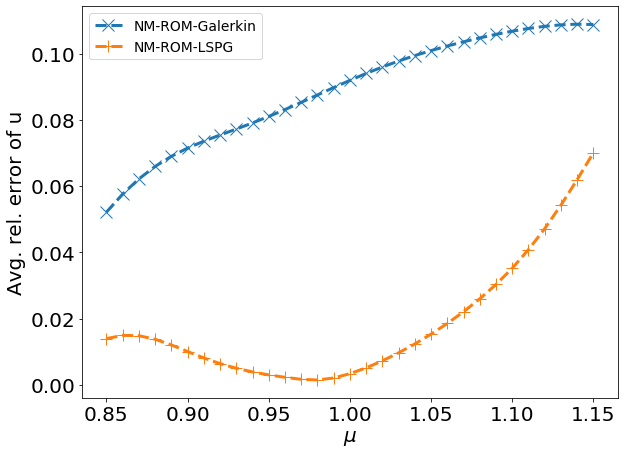

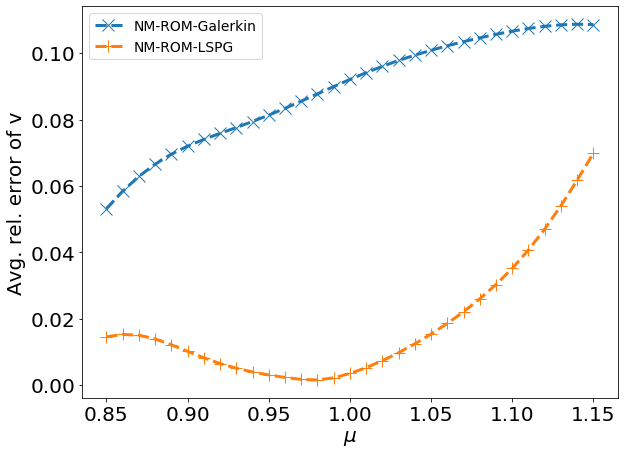

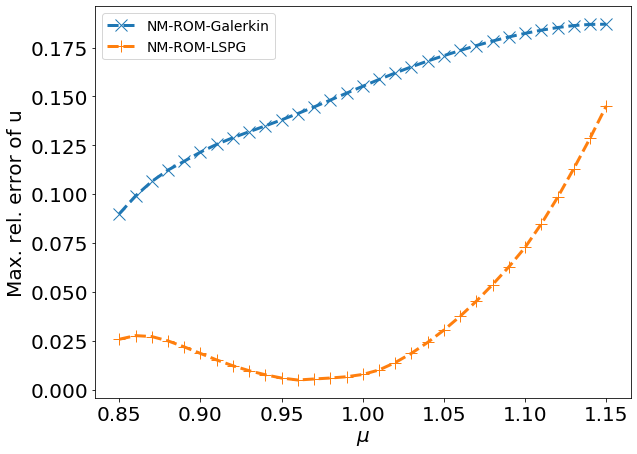

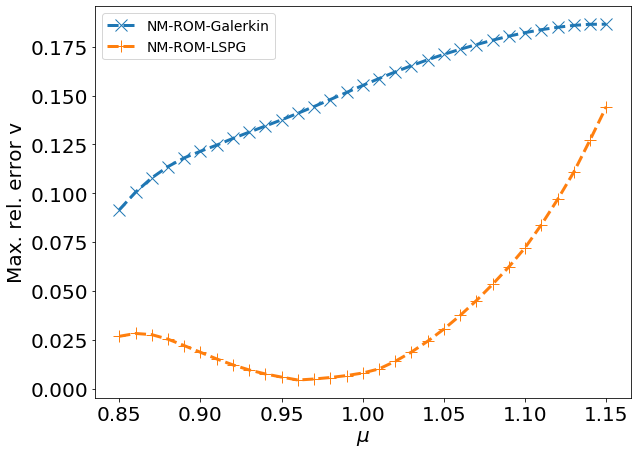

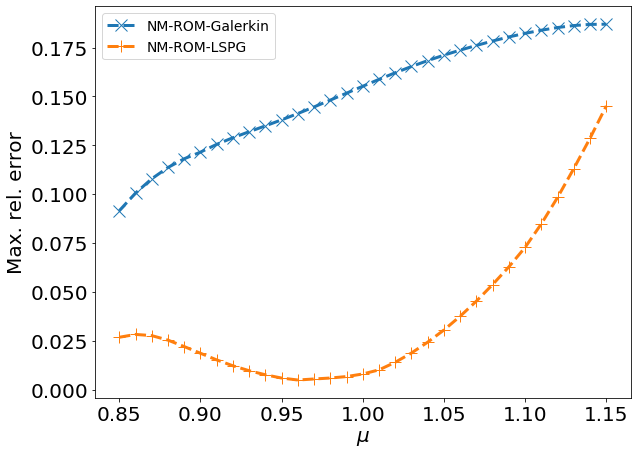

In [13]:
plt.rcParams.update({'font.size': 20})
plt.figure(figsize=(1.5*6.4, 1.5*4.8))
plt.plot(ampArr,1e-2*resultArrGalerkin[:,-5],'x--',ampArr,1e-2*resultArrLSPG[:,-5],'+--',linewidth=3,markersize=12)
plt.xlabel(r'$\mu$')
plt.ylabel('Avg. rel. error of u')
plt.legend(['NM-ROM-Galerkin','NM-ROM-LSPG'],fontsize='x-small')
plt.show()

plt.rcParams.update({'font.size': 20})
plt.figure(figsize=(1.5*6.4, 1.5*4.8))
plt.plot(ampArr,1e-2*resultArrGalerkin[:,-4],'x--',ampArr,1e-2*resultArrLSPG[:,-4],'+--',linewidth=3,markersize=12)
plt.xlabel(r'$\mu$')
plt.ylabel('Avg. rel. error of v')
plt.legend(['NM-ROM-Galerkin','NM-ROM-LSPG'],fontsize='x-small')
plt.show()

plt.rcParams.update({'font.size': 20})
plt.figure(figsize=(1.5*6.4, 1.5*4.8))
plt.plot(ampArr,1e-2*resultArrGalerkin[:,-3],'x--',ampArr,1e-2*resultArrLSPG[:,-3],'+--',linewidth=3,markersize=12)
plt.xlabel(r'$\mu$')
plt.ylabel('Max. rel. error of u')
plt.legend(['NM-ROM-Galerkin','NM-ROM-LSPG'],fontsize='x-small')
plt.show()

plt.rcParams.update({'font.size': 20})
plt.figure(figsize=(1.5*6.4, 1.5*4.8))
plt.plot(ampArr,1e-2*resultArrGalerkin[:,-2],'x--',ampArr,1e-2*resultArrLSPG[:,-2],'+--',linewidth=3,markersize=12)
plt.xlabel(r'$\mu$')
plt.ylabel('Max. rel. error v')
plt.legend(['NM-ROM-Galerkin','NM-ROM-LSPG'],fontsize='x-small')
plt.show()

plt.rcParams.update({'font.size': 20})
plt.figure(figsize=(1.5*6.4, 1.5*4.8))
plt.plot(ampArr,1e-2*resultArrGalerkin[:,-1],'x--',ampArr,1e-2*resultArrLSPG[:,-1],'+--',linewidth=3,markersize=12)
plt.xlabel(r'$\mu$')
plt.ylabel('Max. rel. error')
plt.legend(['NM-ROM-Galerkin','NM-ROM-LSPG'],fontsize='x-small')
plt.show()

In [15]:
print('NM-LSPG')
print()
ampArr = resultArrLSPG[:,0]
namp=ampArr.shape[0]
print('{:^6} {:^13} {:^13} {:^13} {:^13} {:^13} {:^13}'\
      .format('param','time_elapsed','avg_rel_err_u','avg_rel_err_v','max_rel_err_u','max_rel_err_v','max_rel_err'))
for iii in range(namp):
    amp=ampArr[iii]
    time_elapsed=resultArrLSPG[iii,1]
    avg_rel_err_u=resultArrLSPG[iii,2]
    avg_rel_err_v=resultArrLSPG[iii,3]
    max_rel_err_u=resultArrLSPG[iii,4]
    max_rel_err_v=resultArrLSPG[iii,5]
    max_rel_err=resultArrLSPG[iii,6]
    
    print('{:^6.2f} {:^13.2f} {:^13.2f} {:^13.2f} {:^13.2f} {:^13.2f} {:^13.2f}'\
          .format(amp,time_elapsed,avg_rel_err_u,avg_rel_err_v,max_rel_err_u,max_rel_err_v,max_rel_err))

NM-LSPG

param  time_elapsed  avg_rel_err_u avg_rel_err_v max_rel_err_u max_rel_err_v  max_rel_err 
 0.85     107.95         1.40          1.45          2.57          2.67          2.67     
 0.86     102.53         1.50          1.53          2.76          2.82          2.82     
 0.87     103.03         1.49          1.50          2.71          2.76          2.76     
 0.88     106.66         1.38          1.39          2.49          2.53          2.53     
 0.89     101.87         1.21          1.22          2.18          2.20          2.20     
 0.90     101.73         1.01          1.02          1.85          1.86          1.86     
 0.91     103.32         0.82          0.82          1.51          1.52          1.52     
 0.92     105.70         0.65          0.65          1.22          1.21          1.22     
 0.93     109.33         0.51          0.51          0.96          0.95          0.96     
 0.94     106.43         0.40          0.40          0.75          0.75          

In [16]:
print('NM-Galerkin')
print()
ampArr = resultArrGalerkin[:,0]
namp=ampArr.shape[0]
print('{:^6} {:^13} {:^13} {:^13} {:^13} {:^13} {:^13}'\
      .format('param','time_elapsed','avg_rel_err_u','avg_rel_err_v','max_rel_err_u','max_rel_err_v','max_rel_err'))
for iii in range(namp):
    amp=ampArr[iii]
    time_elapsed=resultArrGalerkin[iii,1]
    avg_rel_err_u=resultArrGalerkin[iii,2]
    avg_rel_err_v=resultArrGalerkin[iii,3]
    max_rel_err_u=resultArrGalerkin[iii,4]
    max_rel_err_v=resultArrGalerkin[iii,5]
    max_rel_err=resultArrGalerkin[iii,6]
    
    print('{:^6.2f} {:^13.2f} {:^13.2f} {:^13.2f} {:^13.2f} {:^13.2f} {:^13.2f}'\
          .format(amp,time_elapsed,avg_rel_err_u,avg_rel_err_v,max_rel_err_u,max_rel_err_v,max_rel_err))

NM-Galerkin

param  time_elapsed  avg_rel_err_u avg_rel_err_v max_rel_err_u max_rel_err_v  max_rel_err 
 0.85     238.83         5.22          5.31          8.99          9.15          9.15     
 0.86     228.63         5.76          5.84          9.91          10.05         10.05    
 0.87     225.19         6.22          6.29          10.65         10.79         10.79    
 0.88     227.88         6.59          6.66          11.23         11.36         11.36    
 0.89     228.03         6.90          6.95          11.68         11.81         11.81    
 0.90     238.82         7.15          7.20          12.15         12.15         12.15    
 0.91     224.15         7.36          7.40          12.55         12.46         12.55    
 0.92     227.98         7.54          7.58          12.89         12.81         12.89    
 0.93     232.01         7.72          7.76          13.19         13.13         13.19    
 0.94     229.55         7.91          7.94          13.49         13.44     

# Save

In [17]:
resultDic={'LSPG':resultArrLSPG,'Galerkin':resultArrGalerkin}
pickle.dump(resultDic,open('./data/prediction_NM-ROM.p','wb'))
savemat('./data/prediction_NM-ROM.mat',resultDic)